# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from itertools import product
import tqdm

Загружаем данные

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

**1.1 Проверяем данные**

In [3]:
display(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Целевой признак: Exited.
Так как уход клиента — категориальный признак, то задачу будем решать методом классификации.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видим пропуки в параметре Tenure

In [5]:
data['Tenure'] = data['Tenure'].fillna(-1)
print(data.isna().sum())
print(data.duplicated().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
0


Датасет содержить 10000 строк.
Что мы изменим:
- RowNumber - удалим, так как он не несёт полезной нагрузки.
- CustomerId - удалим, так как он не несёт полезной нагрузки.
- Surname - удалим, так как он не несёт полезной нагрузки.   
- CreditScore - исследуем и cохраняем.         
- Geography - исследуем и сохраняем. Возможно вляет на целевой признак. Преобразуем через OHE.
- Gender - исследуем и сохраняем. Возможно вляет на целевой признак. Преобразуем через OHE.
- Age - исследуем и сохраняем. Возможно вляет на целевой признак. Преобразуем через OHE.
- Tenure - исследуем и cохраняем.
- Balance - исследуем и cохраняем.
- NumOfProducts - исследуем и cохраняем.
- HasCrCard - исследуем и cохраняем.
- IsActiveMember - исследуем и cохраняем.
- EstimatedSalary - исследуем и cохраняем.
- **Exited** - наш целевой признак, оставляем.



**1.2 Подготовка датасета**

Создадим новый датасет для ML и назовём data_ml

In [6]:
for_drop = ['RowNumber','CustomerId','Surname']
data_ml = data.drop(for_drop, axis=1)
display(data_ml)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Применяем OHE.

In [7]:
data_ml = pd.get_dummies(data_ml, drop_first=True)
data_ml.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


**1.3 Создаём выбоки для обучения и валидации.**

Так как у нас только один датасет, то мы разделяем наш датасет на 3 части: 60,20,20.

Создаём признаки и целевой признак

In [8]:
features = data_ml.drop('Exited', axis=1)
target = data_ml['Exited']

Создаём обучающий датасет и валидационный.

In [9]:
features_train, features_validtest, target_train, target_validtest = train_test_split(
features, target, train_size=0.6,random_state=12345, stratify=target)

Разделим оставшиеся 40% на 2 равные части (валидационная и тестовая)

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(
features_validtest, target_validtest, train_size=0.5,random_state=12345, stratify=target_validtest)

**1.4 Приводим все данные к одному масштабу**

Приведём численные значения к едином масштабу

In [11]:
numbers = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [12]:
scaler = StandardScaler()
scaler.fit(features_train[numbers])
features_train[numbers] = scaler.transform(features_train[numbers])
features_valid[numbers] = scaler.transform(features_valid[numbers])
features_test[numbers] = scaler.transform(features_test[numbers])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

## Исследование задачи

Мы будем тестировать три модели.

**2.1 Обучаем модели и проверяем**

In [13]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=12345)
    DTC_score = model_DTC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    RFC_score = model_RFC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    LgR_score = model_LgR.fit(features_train, target_train).score(features_valid, target_valid)
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистческая регрессия", LgR_score)

In [14]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.789 случайный лес  0.8645 логистческая регрессия 0.811


**2.2 Проверяем баланс**

In [15]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [16]:
target_valid.value_counts(normalize = 1)

0    0.796
1    0.204
Name: Exited, dtype: float64

Мы наблюдаем существеный дисбаланс в классах.

**2.3 Проверяем на адекватность**

Проверяем соотношение ответов

In [17]:
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=12345)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
    
    
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)
    
    target_predict_constant = pd.Series([0]*len(target_valid))
    
    print('Пропорции ответов:')
    print("дерево решений:")
    print(DTC_share)
    print(accuracy_score(target_valid, model_DTC.predict(features_valid)))
    print()
    print("случайный лес ")
    print(RFC_share)
    print(accuracy_score(target_valid, model_RFC.predict(features_valid)))
    print()
    print("логистческая регрессия")
    print(LgR_share )
    print(accuracy_score(target_valid, model_LgR.predict(features_valid)))
    print()
    print('Константа')
    print(accuracy_score(target_valid, target_predict_constant))


In [18]:
all_models_share(features_train, target_train, features_valid, target_valid)

Пропорции ответов:
дерево решений:
0    0.777
1    0.223
dtype: float64
0.789

случайный лес 
0    0.8675
1    0.1325
dtype: float64
0.8645

логистческая регрессия
0    0.931
1    0.069
dtype: float64
0.811

Константа
0.796


Логистичесая регрессия показывала самую высокую точность, но данная модель выдает 100% одинаковый результат = 0
Сравним качество предсказаний с константной моделью. За константу примем пример 0, так как это значение встречается 80% случаев

Ниже создадим и проверим на константной модели.

In [19]:
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.shape
accuracy_score_constant = accuracy_score(target_valid, target_predict_constant)
print(accuracy_score_constant)

0.796


**2.3 Рассматриваем матрицу ошибок**

In [54]:
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, prediction, ))

In [55]:
model_DTC = DecisionTreeClassifier(random_state=12345)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
print(confusion_matrix(target_valid, DTC_prediction))
print()
rec_prec_f1(target_valid, DTC_prediction)


[[1362  230]
 [ 192  216]]

Полнота 0.5294117647058824
Точность 0.484304932735426
F1-мера 0.5058548009367682
AUC-ROC 0.6924697014484186


Дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложных позитивных предсказания (FP)
Изучим полноту, точность и F1-меру

Низкое значние F1- меры свидетельствует о низком качестве модели, проблема в точности.

In [56]:
model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
print(confusion_matrix(target_valid, RFC_prediction))
print()
rec_prec_f1(target_valid, RFC_prediction)



[[1528   64]
 [ 207  201]]

Полнота 0.49264705882352944
Точность 0.7584905660377359
F1-мера 0.5973254086181279
AUC-ROC 0.7262230268992019


Случайный лес примерно равную пропорцию позитивных и негативных предсказаний, выдает заметно больше качественных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям (FP)

In [57]:
rec_prec_f1(target_valid, RFC_prediction)

Полнота 0.49264705882352944
Точность 0.7584905660377359
F1-мера 0.5973254086181279
AUC-ROC 0.7262230268992019


Мы видим низкий уровень F1 меры. Это свидетельствует о низком качестве модели.

In [58]:
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[1538,   54],
       [ 324,   84]])

Для логистической регрессии расчитаем метрику AUC-ROC

In [59]:
LgR_probabilities_one_valid = model_LgR.predict_proba(features_valid)[:, 1]
auc_roc_LgR = roc_auc_score(target_valid, LgR_probabilities_one_valid)
auc_roc_LgR

0.7875914498965415

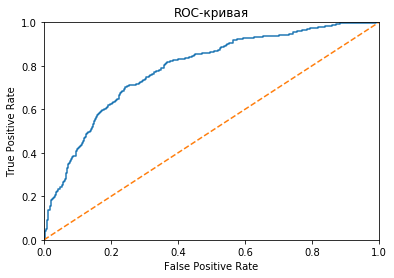

In [60]:
fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Score 0.733
AUC-ROC 0.7938097349492561


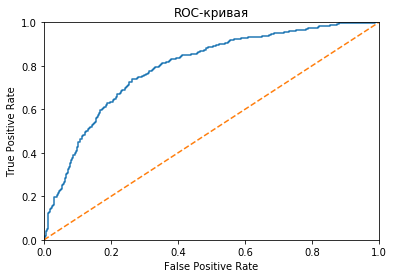

In [61]:
model_LgR = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR.fit(features_train, target_train)
LgR_probabilities_one_valid_class_weight = model_LgR.predict_proba(features_valid)[:, 1]
print("Score", model_LgR.score(features_valid, target_valid))
print("AUC-ROC", roc_auc_score(target_valid, LgR_probabilities_one_valid_class_weight))

fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid_class_weight) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Точность предсказаний не улучшилась.

Логистическая регрессия выдает 100% негативных предсказаний — высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.
Перейдем к формированию сбалансированных выборок

## Борьба с дисбалансом

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%.
Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса.

- Разделим обучающую выборку на отрицательные и положительные объекты;
- Скопируем несколько раз положительные объекты;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.
- Обучим новые модели

In [62]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

Напишем функцию для выравнивания баланса в выборке

In [63]:

def upsample(features, target, repeat, upsampled_сlass):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
        
        
       
    return features_upsampled, target_upsampled

In [64]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 0)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.939904
1    0.060096
Name: Exited, dtype: float64
(20334,)


In [65]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 3)
features_train_upsampled

0

Увеличим количство верных тветов

In [66]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.50569
0    0.49431
Name: Exited, dtype: float64
(9666,)


**Обучение моделей на сбаланированной выборке**

Точность моделей на обычной выборке

In [67]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.789 случайный лес  0.8645 логистческая регрессия 0.811


Точность моделей на сбалансированно выборке

In [68]:
all_models_accuracy(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Точность:дерево решений 0.809 случайный лес  0.852 логистческая регрессия 0.7255


Мы видим, что точность не увеличилась, а по логистической регрессии даже существенно снизилась.

Теперь мы провери качество

In [69]:
print('Решающее дерево')
model_DTC_upsampled = DecisionTreeClassifier(random_state=12345)
model_DTC_upsampled.fit(features_train_upsampled, target_train_upsampled)
DTC_prediction_upsampled = model_DTC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, DTC_prediction_upsampled)


Решающее дерево
Полнота 0.5245098039215687
Точность 0.5323383084577115
F1-мера 0.5283950617283951
AUC-ROC 0.7032096758301309


In [70]:
print('Случайный лес')
model_RFC_upsampled = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, RFC_prediction_upsampled)

Случайный лес
Полнота 0.5759803921568627
Точность 0.6564245810055865
F1-мера 0.6135770234986945
AUC-ROC 0.7493595428120997


In [71]:
print('Логистическая регрессия')
model_LgR_upsampled = LogisticRegression(solver = 'liblinear')
model_LgR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LgR_prediction_upsampled = model_LgR_upsampled.predict(features_valid)
rec_prec_f1(target_valid, LgR_prediction_upsampled)

Логистическая регрессия
Полнота 0.7426470588235294
Точность 0.40562248995983935
F1-мера 0.5246753246753246
AUC-ROC 0.7318762932308602


Показаели всех моделей улучшились.

Лучшие результаты показывает алгоритм случайный лес (RandomForestClassifier). 

На валидационной выборке RandomForestClassifier уже показывает резульаты F1 меры = 0.61, что выше целевого целевого значения.
Попробуем улучшить модель путем изменения параметров.

**Улучшаем модели**

In [72]:
def RandomForestQuality(features_train, target_train, features_valid, target_valid):
    
    #Параметры для перебора
    bootstrap = [True, False]
    class_weight = ['balanced', 'balanced_subsample', None]
    max_features = ['auto', 'sqrt', 'log2'] 
    max_depth = [] #диапазон изменения параметра мксимальной глубины каждого дерева
    for i in range(1, 20):
        max_depth.append(i)

    #Метод itertools.product для перебора нескольких параметров
    myproduct = product(bootstrap, class_weight, max_features, max_depth)
    
    #Строки, котоыре будут наполняться циклом при переборе параметров
    bootstrap_table = []
    class_weight_table = []
    features_table = []
    depth_table = []
    f1_table = []
    recall_table = []
    precision_table = []
    score_train_table = []
    score_valid_table = []
    
    #Цикл перебора всех параметров: bootstrap, class_weight, max_features, max_depth
    for p in tqdm.tqdm(myproduct,):
        #Обучение модели
        model_forest = RandomForestClassifier(
            bootstrap=p[0] , class_weight= p[1], max_features = p[2], max_depth = p[3], 
            n_estimators = 10, random_state=12345)
        model_forest.fit(features_train, target_train)
        prediction = model_forest.predict(features_valid) #предсказание целевого признака
        
        #расчет параметров
        f1 = f1_score(target_valid, prediction)
        recall = recall_score(target_valid, prediction)
        precision = precision_score(target_valid, prediction)
        score_train = model_forest.score(features_train, target_train)
        score_valid = model_forest.score(features_valid, target_valid)
        
        #внесение значиний параметров в строки
        bootstrap_table.append(p[0])
        class_weight_table.append(p[1])
        features_table.append(p[2])
        depth_table.append(p[3])

        #внесение значений метрик в строки
        f1_table.append(f1)
        recall_table.append(recall)
        precision_table.append(precision)
        score_train_table.append(score_train)
        score_valid_table.append(score_valid)
               
    
    #Обоъединение строк в датафрем
    quality_table = pd.DataFrame(data = (
        bootstrap_table, class_weight_table, features_table, depth_table, 
        f1_table, recall_table, precision_table, score_train_table, score_valid_table)).T
    quality_table.columns = (
        'bootstrap', 'class_weight', 'max_features', 'max_depth', 'f1', 'recall', 'precision', 'score_train', 'score_valid')
    return quality_table

    "4 параметра: features_train, target_train — признаки и целевой признак обучающей выборки"
    "features_valid, target_valid — признаки и целевой признак обучающей выборки"

In [73]:
%%time
quality_table = RandomForestQuality(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

342it [01:01,  5.60it/s]

CPU times: user 59.4 s, sys: 241 ms, total: 59.6 s
Wall time: 1min 1s


In [74]:
quality_table.query('score_valid>=score_train').sort_values('f1', ascending = False).head()

,bootstrap,class_weight,max_features,max_depth,f1,recall,precision,score_train,score_valid
177,False,balanced,auto,7,0.636269,0.752451,0.551167,0.813263,0.8245
196,False,balanced,sqrt,7,0.636269,0.752451,0.551167,0.813263,0.8245
272,False,balanced_subsample,log2,7,0.636269,0.752451,0.551167,0.813263,0.8245
253,False,balanced_subsample,sqrt,7,0.636269,0.752451,0.551167,0.813263,0.8245
234,False,balanced_subsample,auto,7,0.636269,0.752451,0.551167,0.813263,0.8245


Лучшие параметры модели:
model = RandomForestClassifier(bootstrap = True, class_weight = 'balanced', max_depth= 7, n_estimators = 10, random_state=12345)

Параметр "max_features" не влияет на параметры модели, оставляем параметр без изменений (default=”auto”)

Обучим финальную модель

In [75]:
model_RFC_final = RandomForestClassifier(
    bootstrap = True, class_weight = 'balanced', max_depth= 7,  n_estimators = 100, random_state=12345)
model_RFC_final.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

In [76]:
model_RFC_final_prediction = model_RFC_final.predict(features_valid)
rec_prec_f1(target_valid, model_RFC_final_prediction)

Полнота 0.7622549019607843
Точность 0.5475352112676056
F1-мера 0.6372950819672132
AUC-ROC 0.8004113705783821


Проверим финальную модель на адекватность

In [77]:
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [78]:
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_valid, model_RFC_final_prediction))
#Дополнительно сравним AUC-ROC — единственный параметр подающийся сравнению, потому что константная подель содержит только негативные ответы
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_valid, model_RFC_final_prediction))

accuracy_score константой модели: 0.796
accuracy_score финальной модели: 0.823
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8004113705783821


Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

**Вывод по результатам исследования**

В первоначальные данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными), из-за чего обученная на этих данных модель не проходила проверку на адекватность. Все модели не первоначальных данных характеризовались высокой степенью ошибок и низким качеством взвешенной величины (F1) — модели показывали низкие результаты точности и полноты.

Мы устранили дисбаланс классов в обучающей выборки методом upsampling — увеличили количество значений позитивного класса в 4 раза. Так мы достигли баланса классо в обучеющей выборки: 1 = 0.50569, 0 = 0.49431.

На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели случайного леса:
- Полнота 0.5784313725490197
- Точность 0.6880466472303207
- F1-мера 0.6284953395472703
- AUC-ROC 0.755610158636319

Было принято решение продолжать улучшение модели на основании алгоритма случайный лес (RandomForestClassifier)

Улучшение модели происходило путем цикла выбора параметров, которые показывали наиболее высокое значение F1 меры и не приводили модель к переобучению. Изменяемые параметры: bootstrap, class_weight, max_depth от 1 до 19 Параметр n_estimators был занижен для ускорения выполнения цикла

Финальные параметры выбранной модели RandomForestClassifier(bootstrap = True, class_weight = 'balanced', max_depth= 7, n_estimators = 100, random_state=12345).
Результаты модели:
- Полнота 0.755
- Точность 0.549
- F1-мера 0.636
- AUC-ROC 0.798

Финальная модель прошла проверку на адекватность в сравнении с контантной моделью: 
- accuracy_score константой модели: 0.796
- accuracy_score финальной модели: 0.8235
- AUC-ROC константой модели: 0.5
- AUC-ROC финальной модели: 0.798

## Тестирование модели

In [82]:
model_RFC_final
model_RFC_final_prediction = model_RFC_final.predict(features_test)
#rec_prec_f1(target_test, model_RFC_final_prediction)

print("Полнота" , recall_score(target_valid, model_RFC_final_prediction))
print("Точность", precision_score(target_valid, model_RFC_final_prediction))
print("F1-мера", f1_score(target_valid, model_RFC_final_prediction))

probabilities_valid = model_RFC_final.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC', auc_roc)

Полнота 0.25735294117647056
Точность 0.1881720430107527
F1-мера 0.21739130434782608
AUC-ROC 0.8556029064503641


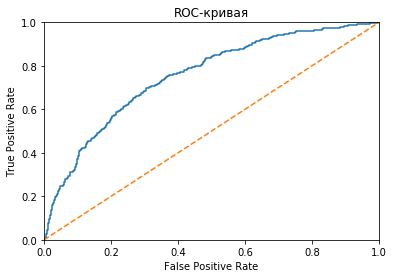

In [80]:
final_model_probabilities_one = model_LgR.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Финальная достигла заданой метрики (F1 > 0.59) и показывает адекватные результаты.
Модель характеризуется высоким показателем полноты = 0.715 (min = 0, max = 1), поэтому она с высокой вероятностью предскажит уход клиента из банка.
Показатель точности не высокий = 0.54 (min = 0, max = 1) — модель верно предсказывает только половину ухода клиентов.
С точки зрения бизнеса полученная модель поможет маркетологам лучше определять килентов, которые могут уйти в ближайшее время. Важно, что мы меньше ошибаемся в плане ложно-положительных сигналов и если мы предсказываем, то предсказание носит высокий уровень надёжности.
